In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import Timedelta
import warnings
import itertools

warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme()
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
sessions = pd.read_json("data/sessions.jsonl", lines=True)
artists = pd.read_json("data/artists.jsonl", lines=True)
tracks = pd.read_json("data/tracks.jsonl", lines=True)
track_storage = pd.read_json("data/track_storage.jsonl", lines=True)
users = pd.read_json("data/users.jsonl", lines=True)
genres = tracks.join(artists.set_index('id')['genres'], on='id_artist', rsuffix='_author').set_index('id')['genres']

def genres_similarity(genres1, genres2):
    simillarity = 0
    for g1, g2 in itertools.product(genres1, genres2):
        indicator = 2
        if g1 != g2:
            words_genre1 = set(g1.lower().split())
            words_genre2 = set(g2.lower().split())
            indicator = 1 if any(word in words_genre2 for word in words_genre1) else 0
        simillarity += indicator
    return simillarity
    


# Analiza braków

In [ ]:
sessions.isnull().mean()

In [ ]:
artists.isnull().mean()
artists.genres.explode().value_counts()

In [ ]:
tracks.isnull().mean()

In [ ]:
track_storage.isnull().sum()

In [ ]:
users.isnull().sum()

# Analiza informatywnosci

In [ ]:
def extract_release_date(tdf: pd.DataFrame):
    def standardize_date(date):
        parts = date.split('-')
        if len(parts) == 1:  # Only year
            return f"{parts[0]}-01-01"
        elif len(parts) == 2:  # Year and month
            return f"{parts[0]}-{parts[1]}-01"
        return date
    
    def date_completeness(date):
        parts = len(date.split('-'))
        if parts == 1:
            return 'year'
        elif parts == 2:
            return 'year_month'
        return 'full_date'
    
    tdf['standardized_date'] = pd.to_datetime(tdf['release_date'].apply(standardize_date))
    tdf['release_year'] = tdf['standardized_date'].dt.year
    tdf['release_daymonth'] = tdf['standardized_date'].dt.dayofyear
    tdf['date_completeness'] = tdf['release_date'].apply(date_completeness)

    return tdf.drop(columns=['standardized_date'])
tracks = pd.read_json("data/tracks.jsonl", lines=True)
tracks = extract_release_date(tracks).drop(columns=['release_date', 'mode'])

In [ ]:
# block is group of consecutive user interactions with song
def transform_block(df: pd.DataFrame):
    
    def define_block_duration(group: pd.DataFrame):
        if 'skip' not in group['event_type'].values:
            return pd.Timedelta(milliseconds=min(group['duration_ms']))
        return max(group['timestamp'])-min(group['timestamp'])
    
    return df.groupby('block_id').agg(
        isskipped=('event_type', lambda x: 'skip' in x.values),
        isliked=('event_type', lambda x: 'like' in x.values),
        timestamp=('timestamp', lambda x: min(x)),
        track_id=('track_id', 'first'),
        user_id=('user_id', 'first'),
        block_duration = ('timestamp', lambda x: define_block_duration(df))
    ).reset_index(drop=True)

def transform_session(session: pd.DataFrame):
    session['block_id'] = (session['track_id'] != session['track_id'].shift()).cumsum()
    session = session.groupby('block_id').apply(transform_block).reset_index(drop=True)
    
    session['session_duration'] = session['block_duration'].cumsum().shift(fill_value=Timedelta(0))
    session['session_skip_count'] = session['isskipped'].cumsum().shift(fill_value=0)
    session['session_like_count'] = session['isliked'].cumsum().shift(fill_value=0)
    session['session_play_count'] = range(len(session))
    
    session['session_skip_rate'] = (session['session_skip_count'] / session['session_play_count']).fillna(0)
    session.replace(np.inf, 0, inplace=True)
    
    session['session_ewma_rate'] = session['isskipped'].astype(int).ewm(alpha=0.8).mean().shift(fill_value=0)

    return session



def transform_user(user: pd.DataFrame):
    user['user_listen_time'] = user['block_duration'].cumsum().shift(fill_value=Timedelta(0))
    user['user_skip_count'] = user['isskipped'].cumsum().shift(fill_value=0)
    user['user_like_count'] = user['isliked'].cumsum().shift(fill_value=0)
    user['user_play_count'] = range(len(user))
    user['user_skip_rate'] = (user['user_skip_count'] / user['user_play_count']).fillna(0)
    user.replace(np.inf, 0, inplace=True)
    user['user_ewma_rate'] = user['isskipped'].astype(int).ewm(alpha=0.8).mean().shift(fill_value=0)
    return user

df = sessions[sessions['event_type'].isin(['play', 'skip', 'like'])]
df = df.merge(tracks[['id', 'duration_ms']].set_index('id'), left_on="track_id", right_on='id')
df = df.groupby('session_id').apply(transform_session).reset_index().drop(columns=['level_1'])

df = df.groupby('user_id').apply(transform_user).reset_index(drop=True)

df = df.join(users.set_index('user_id'), on='user_id', rsuffix="_user").join(genres, on="track_id").join(tracks.set_index('id'), on="track_id", rsuffix="_track")
df['fav_genres_similarity'] = df.apply(lambda x: genres_similarity(x['genres'], x['favourite_genres']), axis=1)

# df.to_csv("data/result.csv")
target_df=df.drop(columns=[col for col in df.columns if 'id' in col])
target_df

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
def preprocess_dataset(df: pd.DataFrame):
    final_dataset = df.dropna()
    label_encoder = LabelEncoder()
    final_dataset['city'] = label_encoder.fit_transform(final_dataset['city'])
    
    final_dataset['day']=final_dataset['timestamp'].dt.dayofyear
    final_dataset['hourminute']= final_dataset['timestamp'].dt.hour * 60 + final_dataset['timestamp'].dt.minute
    final_dataset['date_completeness'] = label_encoder.fit_transform(final_dataset['date_completeness'])
    
    final_dataset = final_dataset.drop(columns=['block_duration'])
    final_dataset['session_duration']=final_dataset['session_duration'].apply(lambda x: x.total_seconds())
    final_dataset['user_listen_time']=final_dataset['user_listen_time'].apply(lambda x: x.total_seconds())
    
    final_dataset['premium_user']=final_dataset['premium_user'].astype(int)
    final_dataset['isliked']=final_dataset['isliked'].astype(int)
    final_dataset['isskipped']=final_dataset['isskipped'].astype(int)
    
    # numeric_cols = final_dataset.select_dtypes(include=['float64']).columns
    # scaler = StandardScaler()
    # final_dataset[numeric_cols] = scaler.fit_transform(final_dataset[numeric_cols])
    
    return final_dataset.drop(columns=['timestamp', 'street', 'key', 'time_signature', 'explicit', 'name_track', 'name'])
final_dataset = preprocess_dataset(target_df)
final_dataset

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

final_dataset = preprocess_dataset(target_df)
Y = final_dataset['isskipped']
X = final_dataset.drop(columns='isskipped')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot()

# feature_importances = clf.feature_importances_
# feature_names = X.columns
# importances = pd.Series(feature_importances, index=feature_names)
# importances_sorted = importances.sort_values()
# importances_sorted.plot(kind='barh', color='lightblue')
# plt.title('Features Importance in Random Forest Model')
plt.show()

# EDA

## Pytania
- informatywność
    - samych danych audio
    - średnia stosunek przewijania piosenek użytkownika/sesji
    - gatunki piosenki i ulubione gatunki uzytkownika
    - popularność piosenki w danym czasie
    - pora dnia, dzień tygodia, miesiąc
    - poprzednia piosenka
    - długość piosenki
    - użytkownik premium
    - stosunek przesłuchania piosenek przez użytkownika
    - polikownaie
- czy przez klastrowanie - ogólne zachowanie użytkownika - stworzy się przydatną zmienną
- czy poprzednia piosenka ma wpływ na zachowanie użytkownika
- czy like,adv ma wpływ na zachowanie użytkownika 

In [ ]:
def plot_heat_corr(X: pd.DataFrame, Y: pd.DataFrame):
    corr = X.corrwith(Y).to_frame().T
    corr.index = ['isskipped']
    f, ax = plt.subplots(figsize=(24, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
analyze_df = pd.read_csv('data/result.csv', index_col=0, parse_dates=['timestamp'], converters={
    'block_duration': lambda x: pd.to_timedelta(x),
    'session_duration': lambda x: pd.to_timedelta(x),
    'user_listen_time': lambda x: pd.to_timedelta(x),
})
analyze_df

## Analiza danych audio

In [ ]:

plot_heat_corr(analyze_df.loc[:, 'danceability':'time_signature'], analyze_df['isskipped'])

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X = analyze_df.loc[:, 'danceability':'time_signature'].drop(columns=['mode']).values
pca = PCA(n_components=2)
principal_components = pca.fit_transform(StandardScaler().fit_transform(X))
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
df=pd.concat([pca_df, analyze_df['isskipped']],axis=1)
sns.scatterplot(df[df['isskipped']==False], x='PC1', y='PC2', label="Not skipped", alpha=0.6)
sns.scatterplot(df[df['isskipped']==True], x='PC1', y='PC2', label="Skipped", alpha=0.6)

## Analiza wpływu czasu

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 2))
analyze_df.resample('M', on="timestamp").count()['isskipped'].plot(ax=axs[0], title="Songs played")
analyze_df.resample('M', on="timestamp").agg(skips=('isskipped', 'mean')).plot(ax=axs[1], title="Songs skip rate")

In [ ]:
import calendar
fig = plt.figure(figsize=(18, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132, sharey=ax1)

weekend = ['Friday', 'Saturday', 'Sunday']
df = analyze_df
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.to_period('M').dt.to_timestamp()
df = df.groupby(['month', 'dayofweek'])['isskipped'].mean().reset_index().pivot_table(index='month', columns='dayofweek', values='isskipped')
df.rename(columns={i: day for i, day in enumerate(calendar.day_name)}, inplace=True)

df[weekend].plot(ax=ax1, title="Weekend")
df[ df.columns.difference(weekend)].plot(ax=ax2, title="Working day")
df.mean(axis=0).plot(kind='bar', ax=fig.add_subplot(133))

## Analiza wpływu gatunku

In [ ]:
df = analyze_df[['isskipped', 'fav_genres_similarity']]
df.corr()

In [ ]:
_, df = next(iter(analyze_df.groupby('session_id')))
df['genres']

In [519]:
from scipy.sparse import csr_matrix, vstack, hstack
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
all_genres = genres.explode().unique()

def genre_similarity(g1, g2):
    g1_words = set(g1.lower().split())
    g2_words = set(g2.lower().split())
    return len(g1_words.intersection(g2_words))/(len(g1_words.union(g2_words)))

def encode_track(track_genres):
    row_indices, col_indices, data = [], [], []
    for i, track_genre in enumerate(track_genres):
        for j, other_genre in enumerate(all_genres):
            similarity = genre_similarity(track_genre, other_genre)
            if similarity != 0:
                row_indices.append(i)
                col_indices.append(j)
                data.append(similarity)
    return csr_matrix(csr_matrix((data, (row_indices, col_indices)), shape=(len(track_genres), len(all_genres))).sum(axis=0))

# columns_of_interest = ['session_id', 'id_artist', 'user_id', 'timestamp', 'isskipped', 'genres', 'favourite_genres']
genres_analyze_df = analyze_df
artists_df = artists[artists['id'].isin(genres_analyze_df['id_artist'].values)].set_index('id')[['genres']].map(encode_track)
users_df = users[users['user_id'].isin(genres_analyze_df['user_id'].values)].set_index('user_id')[['favourite_genres']].map(encode_track)
genres_analyze_df=genres_analyze_df.join(artists_df, on='id_artist', rsuffix='_vector').join(users_df, on='user_id', rsuffix='_vector').drop(columns=['genres', 'favourite_genres'])

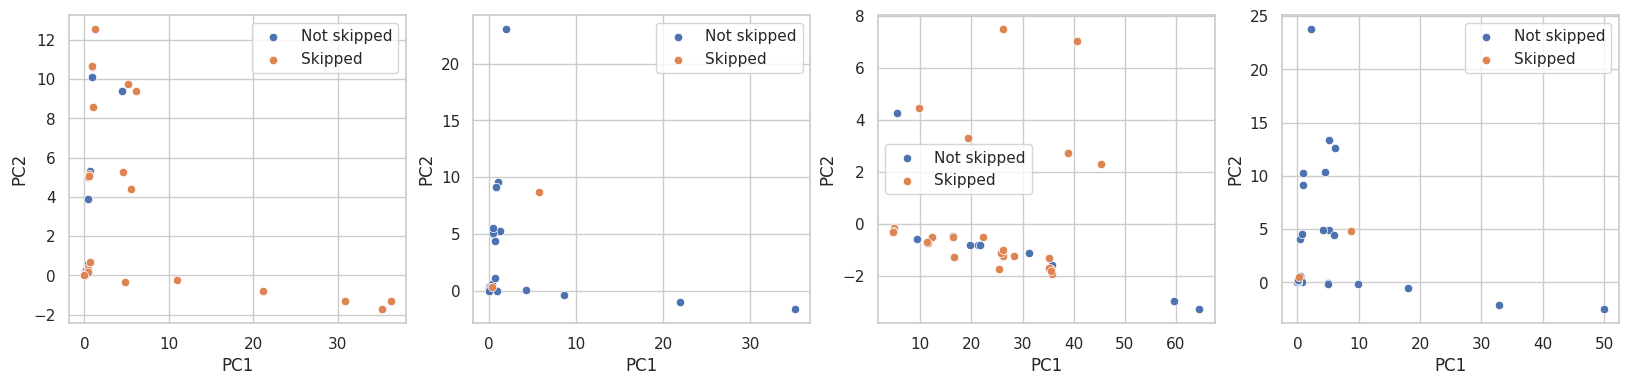

In [522]:
# Choose the longest sessions with different users
idxs = genres_analyze_df.groupby(['session_id', 'user_id'])['session_id'].size().reset_index(name='count').sort_values(['user_id', 'count'], ascending=[True, False]).groupby('user_id').head(1).nlargest(4, 'count')['session_id'].values
columns_of_interest = ['session_id', 'id_artist', 'user_id', 'timestamp', 'isskipped', 'genres', 'favourite_genres']
sessions_df = genres_analyze_df[genres_analyze_df['session_id'].isin(idxs)]
artists_df = artists[artists['id'].isin(sessions_df['id_artist'].values)].set_index('id')[['genres']].map(encode_track)
users_df = users[users['user_id'].isin(sessions_df['user_id'].values)].set_index('user_id')[['favourite_genres']].map(encode_track)
sessions_df=sessions_df.join(artists_df, on='id_artist', rsuffix='_vector').join(users_df, on='user_id', rsuffix='_vector').drop(columns=['genres', 'favourite_genres'])

svd = TruncatedSVD(n_components=2)
pca_df = pd.DataFrame(data=svd.fit_transform(vstack(sessions_df['genres_vector'])), columns=['PC1', 'PC2'])
fdf=pd.concat([pca_df, sessions_df[['isskipped', 'session_id']].reset_index(drop=True)],axis=1)

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
for i, (_, df) in enumerate(fdf.groupby('session_id')):
    sns.scatterplot(df[df['isskipped']==False], x='PC1', y='PC2', label="Not skipped", ax=axs[i])
    sns.scatterplot(df[df['isskipped']==True], x='PC1', y='PC2', label="Skipped", ax=axs[i])

In [520]:

genres_analyze_df['similarity']=genres_analyze_df.apply(lambda x: cosine_similarity(x['genres_vector'], x['favourite_genres_vector'])[0, 0], axis=1)
print(genres_analyze_df[['similarity', 'isskipped']].corr())

def sim(group: pd.DataFrame):
    was_skipped = group[group['isskipped']==True]
    not_skipped = group[group['isskipped']==False]
    if len(was_skipped)<=0 or len(not_skipped) <=0:
        return {
        'skip': None,
        'notskip': None
    }
    a=csr_matrix(vstack(was_skipped['genres_vector']).mean(axis=0))
    c=csr_matrix(vstack(not_skipped['genres_vector']).mean(axis=0))
    b=csr_matrix(vstack(group['favourite_genres_vector']).mean(axis=0))
    return {
        'skip': cosine_similarity(a, b)[0, 0],
        'notskip': cosine_similarity(c, b)[0, 0]
    }
pd.DataFrame([sim(group) for _, group in genres_analyze_df.groupby('session_id')]).dropna().agg(['mean', 'std'])

            similarity  isskipped
similarity      1.0000     0.0287
isskipped       0.0287     1.0000


,skip,notskip
mean,0.479578,0.534078
std,0.335565,0.319727


## Analiza wpływu poprzedniej piosenki

In [ ]:
df = pd.DataFrame(analyze_df[['session_id', 'isskipped']])
df['skip_changed']=(df['isskipped']==True) & (df['isskipped']!= df['isskipped'].shift(fill_value=False))
df.groupby('session_id').filter(lambda x: x['isskipped'].values.sum()>1).groupby('session_id')['skip_changed'].sum().reset_index(drop=True).hist(bins=40)

In [ ]:
df = analyze_df
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df=df[df.timestamp.dt.month==11]
df.drop(columns=['timestamp']).groupby('hour').agg(skips=('isskipped', 'sum')).plot()
it = iter(df.resample('2H', on="timestamp"))
_, df = next(it)
df